# Machine Learning I Final Project

Team 4

Rebecca Li, Jackie Li, Chris Chou, Niki Baskar

In [391]:
# import packages
import pandas as pd
from datetime import datetime
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Embedding, Flatten, Input, concatenate
from keras_tuner import BayesianOptimization, RandomSearch
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import keras.backend as K
import sklearn
import category_encoders as ce
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import log_loss
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras import initializers
from datatable import dt, f, by, g, join, sort, update, ifelse
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Data Exploration

## Data Import

In [392]:
# Import the training data
train = pd.read_csv('Project Data/ProjectTrainingData.csv')

KeyboardInterrupt: 

In [ ]:
# Import the test data
test = pd.read_csv('Project Data/ProjectTestData.csv')

In [ ]:
train.shape
# there are 31991090 rows and 24 columns

(31991090, 24)

In [ ]:
# shuffle the train dataset into 10 parts
shuffled = train.sample(frac=1)
result = np.array_split(shuffled, 10)  

In [ ]:
# name those parts with number
for i in range(len(result)):
    exec(f'train_{i} = result[i]')

In [ ]:
print(train_1.shape)

(3199109, 23)


## Data Overview

In [ ]:
# Explore the training data
train_1.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
11657845,0,14102322,1002,0,others,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,...,0,0,4687,320,50,423,2,39,100148,32
31980697,0,14102923,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,other,0f2161f8,...,1,0,20508,320,50,2351,3,163,-1,61
8274615,0,14102222,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,...,1,0,21836,300,250,2523,0,35,100084,221
1994761,0,14102110,1005,0,85f751fd,c4e18dd6,50e219e0,other,other,cef3e649,...,1,2,21751,320,50,2505,0,169,100176,17
28022319,0,14102819,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,other,0f2161f8,...,1,0,18539,320,50,2104,3,1839,-1,171


In [ ]:
# set test set naive prediction value as 0.5
test['click'] = 0.5
# set test set column names
test = test[['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 
                    'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]

In [ ]:
test.shape

(13015341, 24)

In [ ]:
train_1.describe(include='all')

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3199109,3199109,3199109,3199109,3199109,3199109,...,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06
unique,NaN,NaN,NaN,NaN,3288,4027,22,4512,288,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,85f751fd,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,1117132,1160119,1273308,2081977,2199289,2110065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.698495e-01,1.410251e+07,1.004972e+03,2.944567e-01,NaN,NaN,NaN,NaN,NaN,NaN,...,1.018467e+00,3.285399e-01,1.859197e+04,3.188324e+02,6.015709e+01,2.081572e+03,1.433127e+00,2.217013e+02,5.363401e+04,8.057465e+01
std,3.755006e-01,2.675728e+02,1.117449e+00,5.108791e-01,NaN,NaN,NaN,NaN,NaN,NaN,...,5.414683e-01,8.564783e-01,4.968482e+03,2.152290e+01,4.757492e+01,6.089514e+02,1.323373e+00,3.494716e+02,4.992850e+04,6.699900e+01
min,0.000000e+00,1.410210e+07,1.001000e+03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,3.750000e+02,1.200000e+02,2.000000e+01,1.120000e+02,0.000000e+00,3.300000e+01,-1.000000e+00,1.000000e+00
25%,0.000000e+00,1.410222e+07,1.005000e+03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,0.000000e+00,1.668500e+04,3.200000e+02,5.000000e+01,1.800000e+03,0.000000e+00,3.500000e+01,-1.000000e+00,2.300000e+01
50%,0.000000e+00,1.410251e+07,1.005000e+03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,0.000000e+00,2.015300e+04,3.200000e+02,5.000000e+01,2.299000e+03,2.000000e+00,3.900000e+01,1.000550e+05,6.100000e+01
75%,0.000000e+00,1.410280e+07,1.005000e+03,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,0.000000e+00,2.177000e+04,3.200000e+02,5.000000e+01,2.506000e+03,3.000000e+00,1.690000e+02,1.000940e+05,9.100000e+01


In [ ]:
# concat all data to explore
df = pd.concat([train, test])
# transform into a datatable just in case of speed limit
all_dt = dt.Frame(df)

## Categorical Data Encoding

Category with names:
* id: drop
* site categories:
  * site_id: base 5 encoding
  * site_domain: base 5 encoding
  * site_category: base 10 encoding
* app cats:
  * app_id: base 5 encoding
  * app_domain: one-hot encoding
  * app_category: base 10 encoding
* device cats:
  * device_id: one-hot encoding
  * device_ip: drop
  * device_model: base 10 encoding


Category without names:
* C1: stay same
* C14: base 5 encoding
* C15: stay same
* C16: stay same
* C17: base 5 encoding
* C18: stay same
* C19: base 5 encoding
* C20: base 5 encoding
* C21: base 5 encoding

In [ ]:
# drop id in column
del train_2['id']
del test['id']

In [ ]:
# define a function to transform skewed categorical value based on frequency
def categorical_replace(train_data, test_data, column, pct = 0.01):
    """
    train_data: train dataset to input
    test_data: test to input
    column: column name string to input
    pct: transform frequency treshold, default 0.01
    """
    cond = train_data[column].value_counts(normalize = True) > pct
    non_others = cond[cond].index  # define a list to save main category

    train_data['temp'] = 'other'
    train_data.loc[train_data[column].isin(non_others),'temp'] = train_data[column]
    train_data[column] = train_data['temp'].values
    del train_data['temp']
    print("Train Test Replace Finished!")

    test_data['temp'] = 'other'
    test_data.loc[test_data[column].isin(non_others),'temp'] = test_data[column]
    test_data[column] = test_data['temp'].values
    del test_data['temp']
    print("Test data replace finished!")

In [ ]:
# define function to draw category distribution
def hist_bar_cat(data, column):
    categories = data[column].value_counts().index.astype('str')
    counts = data[column].value_counts().values
    plt.bar(categories, counts, width=0.5)
    plt.title('Distribution for column {}'.format(column))

### Site Categories

#### site_id

In [ ]:
# check the number of unique values for each column
train_2['site_id'].nunique()

3313

In [ ]:
train_2['site_id'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

44.17118709525173

In [ ]:
categorical_replace(train_2, test, 'site_id')

Train Test Replace Finished!
Test data replace finished!


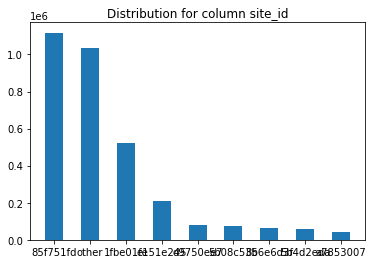

In [ ]:
hist_bar_cat(train_2, "site_id")
# much better

#### site_domain

In [ ]:
train_2['site_domain'].nunique()
# check non-dup value

4040

In [ ]:
train_2['site_domain'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

48.307049944250075

In [ ]:
categorical_replace(train_2, test, 'site_domain')

Train Test Replace Finished!
Test data replace finished!


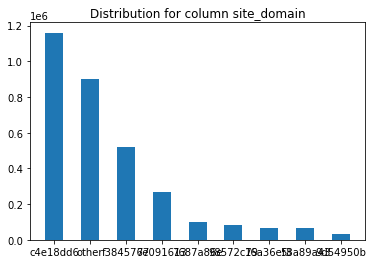

In [ ]:
hist_bar_cat(train_2, "site_domain")
# much better

#### site_category

Use Label Encoder Later

In [ ]:
train_2['site_category'].nunique()

23

### App Categories
#### app_id

In [ ]:
train_2['app_id'].nunique()

4599

In [ ]:
train_2['app_id'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

66.84903587519075

Train Test Replace Finished!
Test data replace finished!


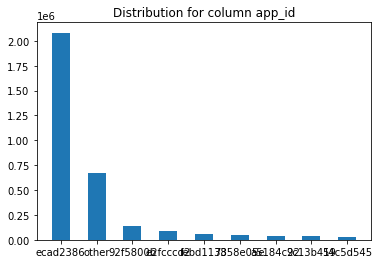

In [ ]:
categorical_replace(train_2, test, 'app_id')
hist_bar_cat(train_2, "app_id")

#### app_domain

In [ ]:
train_2['app_domain'].nunique()

284

In [ ]:
train_2['app_domain'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

16.004398608955334

Train Test Replace Finished!
Test data replace finished!


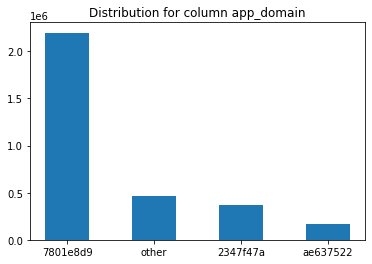

In [ ]:
categorical_replace(train_2, test, 'app_domain', pct = 0.05)
hist_bar_cat(train_2, "app_domain")

#### app_category

Label Encode Later

In [ ]:
train_2['app_category'].nunique()

28

### Device Categoris
#### device_id

In [ ]:
train_2['device_id'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

646.0856545026822

Train Test Replace Finished!
Test data replace finished!


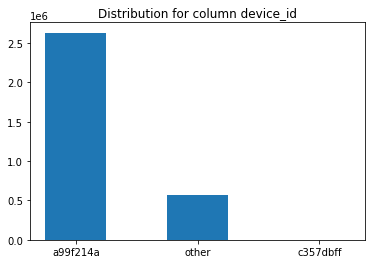

In [ ]:
categorical_replace(train_2, test, 'device_id', pct = 0.0005)
hist_bar_cat(train_2, "device_id")

#### device_ip

In [ ]:
train_2['device_ip'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

254.90205677357898

In [ ]:
#categorical_replace(train_2, test, 'device_ip')
#hist_bar_cat(train_2, "device_ip")

This variable is too skew that we decide to drop it.

In [ ]:
del train_2['device_ip']
del test['device_ip']

#### device_model

In [ ]:
train_2['device_model'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

26.114971214156565

In [ ]:
# categorical_replace(train_2, test, 'device_model')
# hist_bar_cat(train_2, "device_model")

### Anonymized Categorical Variables

#### C14

In [ ]:
train_2['C14'].nunique()

2299

In [ ]:
train_2['C14'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

8.039760129862776

Train Test Replace Finished!
Test data replace finished!


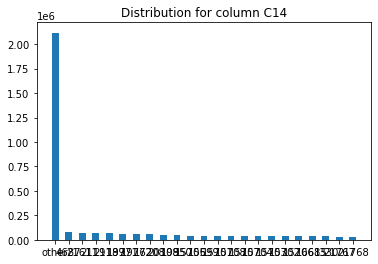

In [ ]:
categorical_replace(train_2, test, 'C14', pct = 0.01)
hist_bar_cat(train_2, "C14")

#### C17

In [ ]:
train_2['C17'].nunique()

403

In [ ]:
train_2['C17'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

10.1668646292013

Train Test Replace Finished!
Test data replace finished!


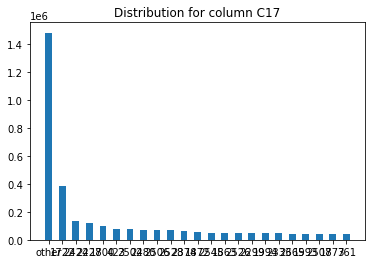

In [ ]:
categorical_replace(train_2, test, 'C17')
hist_bar_cat(train_2, "C17")

#### C19

In [ ]:
train_2['C19'].nunique()

65

In [ ]:
train_2['C19'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

5.250581957882213

Train Test Replace Finished!
Test data replace finished!


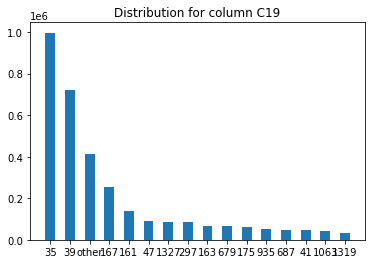

In [ ]:
categorical_replace(train_2, test, 'C19')
hist_bar_cat(train_2, "C19")

#### C20

In [ ]:
train_2['C20'].nunique()

165

In [ ]:
train_2['C20'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

11.77520744584122

Train Test Replace Finished!
Test data replace finished!


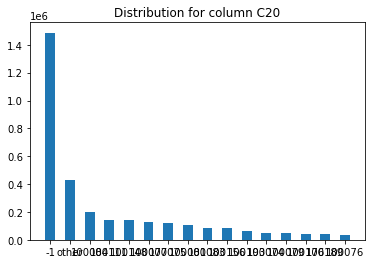

In [ ]:
categorical_replace(train_2, test, 'C20')
hist_bar_cat(train_2, "C20")

#### C21

In [ ]:
train_2['C21'].nunique()

55

In [ ]:
train_2['C21'].value_counts(normalize = True).skew()
# as shown below, the skewness it is not quite high

3.6167089440984204

In [ ]:
categorical_replace(train_2, test, 'C21')

Train Test Replace Finished!
Test data replace finished!


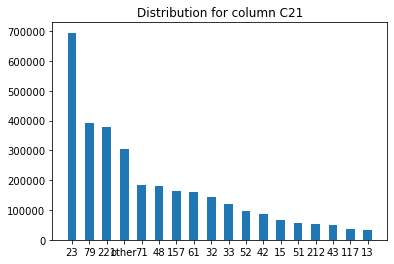

In [ ]:
hist_bar_cat(train_2, "C21")

### Encoding

#### One-hot

In [ ]:
# one-hot encoding: app_domain, device_id
encoder=ce.OneHotEncoder(cols=['app_domain','device_id'],handle_unknown='return_nan',return_df=True,use_cat_names=True)
one_hot_encoder = encoder.fit(train_2)

In [ ]:
train_2 = one_hot_encoder.transform(train_2)

In [ ]:
test = one_hot_encoder.transform(test)

#### Base 5 

In [ ]:
# base 5 encoding: site_id, site_domain, app_id, C14, C17, C19, C20, C21
encoder1 = ce.BaseNEncoder(cols=['site_id','site_domain','app_id','C14','C17','C19','C20','C21'], return_df=True, base=5)
base_5_encoder = encoder1.fit(train_2)

In [ ]:
train_2 = base_5_encoder.transform(train_2)

In [ ]:
test = base_5_encoder.transform(test)

#### Base 10

In [ ]:
# base 10 encoding: site_category, app_category, device_model
encoder2 = ce.BaseNEncoder(cols=['site_category','app_category','device_model'], return_df=True, base=10)
base_10_encoder = encoder2.fit(train_2)

In [ ]:
train_2 = base_10_encoder.transform(train_2)

In [ ]:
test = base_10_encoder.transform(test)

## Numerical Variables
* hour: detail shown below
* banner_pos: encoded by professor
* device_type: encoded by professor
* device_conn_type: encoded by professor

### Hour
- Day: week number
- Hour:
  - 1: 00-06
  - 2: 07-12
  - 3: 13-18
  - 4: 19-24

In [ ]:
splitat = 6
train_2['day'], train_2['time'] = train_2['hour'].astype('str').str[:splitat], train_2['hour'].astype('str').str[splitat:].astype('int')

In [ ]:
train_2[['day','time','hour','time_of_day']].head(5)

,day,time,hour,time_of_day
15750896,141025,11,14102511,2
24762741,141028,6,14102806,1
22399012,141027,11,14102711,2
13473481,141024,13,14102413,3
19575831,141026,12,14102612,2


In [ ]:
# time of day
def add_time_of_day(data):
    data['day'], data['time'] = data['hour'].astype('str').str[:splitat], data['hour'].astype('str').str[splitat:].astype('int')
    conditions = [(data.time <=6),
                (data.time > 6) & (data.time <= 12),
                (data.time > 12) & (data.time <= 18),
                (data.time >18)
                ]
    values = [1, 2, 3, 4]
    data['time_of_day'] = np.select(conditions, values, 0)

In [ ]:
#add_time_of_day(train_2)
add_time_of_day(test)

In [ ]:
def add_day_of_week(data):
    data['day']= pd.to_datetime(data['day'],format="%y%m%d")
    data['day_of_week'] = data['day'].dt.dayofweek

In [ ]:
add_day_of_week(train_2)
add_day_of_week(test)

## Finalize the data

In [ ]:
train_2.head()

,click,hour,C1,banner_pos,site_id_0,site_id_1,site_domain_0,site_domain_1,site_category_0,site_category_1,...,C19_0,C19_1,C20_0,C20_1,C21_0,C21_1,day,time,time_of_day,day_of_week
15750896,0,14102511,1010,1,0,1,0,1,0,1,...,0,1,0,1,0,1,2014-10-25,11,2,5
24762741,1,14102806,1005,1,0,2,0,2,0,2,...,0,2,0,2,0,2,2014-10-28,6,1,1
22399012,0,14102711,1005,0,0,1,0,1,0,1,...,0,3,0,3,0,3,2014-10-27,11,2,0
13473481,0,14102413,1005,1,0,2,0,2,0,3,...,0,2,0,1,0,4,2014-10-24,13,3,4
19575831,1,14102612,1005,0,0,3,0,3,0,3,...,0,4,0,4,0,4,2014-10-26,12,2,6


In [ ]:
x_col = ['C1', 'banner_pos', 'site_id_0', 'site_id_1',
       'site_domain_0', 'site_domain_1', 'site_category_0', 'site_category_1',
       'app_id_0', 'app_id_1', 'app_domain_7801e8d9', 'app_domain_ae637522',
       'app_domain_2347f47a', 'app_domain_other', 'app_category_0',
       'app_category_1', 'device_id_other', 'device_id_a99f214a',
       'device_id_c357dbff', 'device_model_0', 'device_model_1',
       'device_model_2', 'device_model_3', 'device_type', 'device_conn_type',
       'C14_0', 'C14_1', 'C15', 'C16', 'C17_0', 'C17_1', 'C18', 'C19_0',
       'C19_1', 'C20_0', 'C20_1', 'C21_0', 'C21_1',
       'time_of_day', 'day_of_week']
y_col = 'click'

In [ ]:
X_train2 = train_2[x_col]
y_train2 = train_2[y_col]
X_test = test[x_col]
y_pred_naive = test[y_col]

# Model Training

In [ ]:
# Split to Sub-train & Validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train2, y_train2, test_size=0.25, random_state=42)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(random_state=42, n_jobs=-1, penalty="l2").fit(X_train, y_train)

/Users/rebecca/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred = lr.predict_proba(X_val)

In [ ]:
# print log loss of the validation data
log_loss(y_val, y_pred)

0.4377968707487963

Since the log-loss is quite high, LR is not a great model to be chosen as a final step.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc=RandomForestClassifier(random_state=42)

Random Serach using random forest

In [ ]:
rs_space={'max_depth':list(np.arange(10, 30, step=10)) + [None],
              'n_estimators':np.arange(100, 300, step=100),
              'max_features':['sqrt', 'log2'],
              'criterion':['gini','entropy'],
              'min_samples_split':[100, 200, 300]
         }

In [ ]:
# param_grid = { 
#     'n_estimators': [100, 200, 300, 400],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 10, 100],
#     'max_depth' : [10,20,30],
# }
# gs_rfc = GridSearchCV(estimator=rfc,
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_log_loss',
#     n_jobs=-1, 
#     verbose = 3)
# gs_rfc.fit(X_train, y_train)

In [ ]:
from tune_sklearn import TuneGridSearchCV

In [ ]:
rfc_random = TuneGridSearchCV(rfc, rs_space, 
                                scoring='neg_log_loss', 
                                n_jobs=-1, 
                                cv=2,
                                verbose=2)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
rfc_random.fit(X_train,y_train)

2022-12-05 16:51:40,809	WARNING tune.py:705 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2022-12-05 16:51:43,524	ERROR tune.py:773 -- Trials did not complete: [_Trainable_a41fa_00000, _Trainable_a41fa_00001, _Trainable_a41fa_00002, _Trainable_a41fa_00003, _Trainable_a41fa_00004, _Trainable_a41fa_00005, _Trainable_a41fa_00006, _Trainable_a41fa_00007, _Trainable_a41fa_00008, _Trainable_a41fa_00009, _Trainable_a41fa_00010, _Trainable_a41fa_00011, _Trainable_a41fa_00012, _Trainable_a41fa_00013, _Trainable_a41fa_00014, _Trainable_a41fa_00015, _Trainable_a41fa_00016, _Trainable_a41fa_00017, _Trainable_a41fa_00018, _Trainable_a41fa_00019, _Trainable_a41fa_00020, _Trainable_a41fa_00021, _Trainable_a41fa_00022, _Trainable_a41fa_00023]
2022-12-05 16:51:43,528	INFO tune.py:777 -- Total run time: 1016.21 seconds (1015.63 seconds for the tuning loop).
202

ZeroDivisionError: division by zero

In [ ]:
print("Parameter: ", rfc_random.best_params_)
print("Non-nested LogLoss: ", rfc_random.best_score_)
print("Best Estimator: ", rfc_random.best_estimator_)

In [ ]:
rf = RandomForestClassifier(n_estimators = 100, 
                            random_state = 42, 
                            min_samples_split=300, 
                            max_depth=30,
                            n_jobs=-1)

rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


building tree 7 of 100
building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.1s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.6min


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


RandomForestClassifier(max_depth=20, max_features='log2', min_samples_split=4,
                       n_jobs=-1, random_state=42, verbose=4)

In [393]:
y_pred_rf = rf.predict_proba(X_val)
log_loss(y_val, y_pred_rf)
# .40227452244706247

ValueError: Input contains NaN.

## Neural Net

In [ ]:
kernel_regularizer = regularizers.l2(0.003),

In [ ]:
# initialize nn
nnc = Sequential()
# add input layer
nnc.add(Dense(10, kernel_regularizer = regularizers.l2(0.003), kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu', input_shape = (X_train.shape[1],), use_bias=True))
nnc.add(Dropout(0.4))
# add hidden layer
nnc.add(Dense(10, kernel_regularizer = regularizers.l2(0.003), kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu'))
nnc.add(Dropout(0.3))
nnc.add(Dense(units = 6, activation = 'sigmoid', use_bias = True))
# add output layer
nnc.add(Dense(1, activation = 'sigmoid', use_bias = True))
nnc.compile(optimizer = Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
nnc.fit(X_train, y_train, epochs=10, batch_size = 512, validation_data = (X_val, y_val))

Epoch 1/5
4687/4687 [==============================] - 9s 2ms/step - loss: 0.4588 - accuracy: 0.8280 - val_loss: 0.4553 - val_accuracy: 0.8304
Epoch 2/5
4687/4687 [==============================] - 7s 1ms/step - loss: 0.4513 - accuracy: 0.8305 - val_loss: 0.4473 - val_accuracy: 0.8304
Epoch 3/5
4687/4687 [==============================] - 7s 1ms/step - loss: 0.4488 - accuracy: 0.8305 - val_loss: 0.4479 - val_accuracy: 0.8304
Epoch 4/5
4687/4687 [==============================] - 8s 2ms/step - loss: 0.4502 - accuracy: 0.8305 - val_loss: 0.4494 - val_accuracy: 0.8304
Epoch 5/5
4687/4687 [==============================] - 9s 2ms/step - loss: 0.4515 - accuracy: 0.8305 - val_loss: 0.4494 - val_accuracy: 0.8304


In [ ]:
y_pred_nn = nnc.predict(X_val)
log_loss(y_val, y_pred_nn)

24994/24994 [==============================] - 17s 665us/step


0.44924784763601544

## LightGBM

In [ ]:
lgb = LGBMClassifier(learning_rate=0.09,random_state=42)

In [ ]:
lgb.fit(X_train,y_train,verbose=3,eval_metric='logloss')

LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [ ]:
parameters = {
    'learning_rate': [0.01,0.05,0.09,0.1],
    'num_leaves': [31,250,300],
}

gbm = LGBMClassifier(objective='binary', 
                          n_jobs=-1,
                          metric = 'binary_logloss',
                          boosting_type='gbdt',
                          cat_smooth= 35)
gs_lgb = GridSearchCV(gbm, param_grid=parameters, scoring='neg_log_loss', cv=3, verbose = 35)

In [ ]:
gs_lgb.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START learning_rate=0.01, num_leaves=31..........................
[CV 1/3; 1/12] END learning_rate=0.01, num_leaves=31;, score=-0.425 total time=  12.4s
[CV 2/3; 1/12] START learning_rate=0.01, num_leaves=31..........................
[CV 2/3; 1/12] END learning_rate=0.01, num_leaves=31;, score=-0.425 total time=   9.9s
[CV 3/3; 1/12] START learning_rate=0.01, num_leaves=31..........................
[CV 3/3; 1/12] END learning_rate=0.01, num_leaves=31;, score=-0.425 total time=   9.8s
[CV 1/3; 2/12] START learning_rate=0.01, num_leaves=250.........................
[CV 1/3; 2/12] END learning_rate=0.01, num_leaves=250;, score=-0.417 total time=  14.9s
[CV 2/3; 2/12] START learning_rate=0.01, num_leaves=250.........................
[CV 2/3; 2/12] END learning_rate=0.01, num_leaves=250;, score=-0.417 total time=  14.9s
[CV 3/3; 2/12] START learning_rate=0.01, num_leaves=250.........................
[CV 3/3; 2/12] E

GridSearchCV(cv=3,
             estimator=LGBMClassifier(cat_smooth=35, metric='binary_logloss',
                                      objective='binary'),
             param_grid={'learning_rate': [0.01, 0.05, 0.09, 0.1],
                         'num_leaves': [31, 250, 300]},
             scoring='neg_log_loss', verbose=35)

In [ ]:
print('best parameter:{0}'.format(gs_lgb.best_params_))
print('best logloss:{0}'.format(-gs_lgb.best_score_))
print(-gs_lgb.cv_results_['mean_test_score'])
print(gs_lgb.cv_results_['params'])

best parameter:{'learning_rate': 0.1, 'num_leaves': 300}
best logloss:0.40284256869548624
[0.42493007 0.4167635  0.4161361  0.41145756 0.40401134 0.4036137
 0.40933394 0.40322167 0.40294127 0.40888987 0.40307371 0.40284257]
[{'learning_rate': 0.01, 'num_leaves': 31}, {'learning_rate': 0.01, 'num_leaves': 250}, {'learning_rate': 0.01, 'num_leaves': 300}, {'learning_rate': 0.05, 'num_leaves': 31}, {'learning_rate': 0.05, 'num_leaves': 250}, {'learning_rate': 0.05, 'num_leaves': 300}, {'learning_rate': 0.09, 'num_leaves': 31}, {'learning_rate': 0.09, 'num_leaves': 250}, {'learning_rate': 0.09, 'num_leaves': 300}, {'learning_rate': 0.1, 'num_leaves': 31}, {'learning_rate': 0.1, 'num_leaves': 250}, {'learning_rate': 0.1, 'num_leaves': 300}]


In [ ]:
lgb = LGBMClassifier(learning_rate=0.1,num_leaves = 300,random_state=42, metric = 'binary_logloss',cat_smooth= 35).\
    fit(X_train, y_train,eval_metric='logloss')

In [ ]:
y_pred_lgb=lgb.predict_proba(X_val)[:, 1]

In [ ]:
log_loss(y_val, y_pred_lgb)

0.40189174104048725

## CatBoost

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
ctb = CatBoostClassifier(random_seed=42, n_jobs = -1)

In [ ]:
ctb.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.285912
0:	learn: 0.5519195	total: 307ms	remaining: 5m 6s
1:	learn: 0.4882444	total: 543ms	remaining: 4m 31s
2:	learn: 0.4565754	total: 783ms	remaining: 4m 20s
3:	learn: 0.4406521	total: 1.05s	remaining: 4m 22s
4:	learn: 0.4320025	total: 1.29s	remaining: 4m 17s
5:	learn: 0.4279447	total: 1.5s	remaining: 4m 8s
6:	learn: 0.4256922	total: 1.73s	remaining: 4m 4s
7:	learn: 0.4235959	total: 2s	remaining: 4m 7s
8:	learn: 0.4219762	total: 2.22s	remaining: 4m 4s
9:	learn: 0.4212122	total: 2.47s	remaining: 4m 4s
10:	learn: 0.4204718	total: 2.73s	remaining: 4m 5s
11:	learn: 0.4198307	total: 2.98s	remaining: 4m 5s
12:	learn: 0.4191626	total: 3.25s	remaining: 4m 7s
13:	learn: 0.4186675	total: 3.54s	remaining: 4m 8s
14:	learn: 0.4183072	total: 3.78s	remaining: 4m 8s
15:	learn: 0.4178105	total: 4.08s	remaining: 4m 10s
16:	learn: 0.4174948	total: 4.46s	remaining: 4m 18s
17:	learn: 0.4171688	total: 4.77s	remaining: 4m 20s
18:	learn: 0.4169273	total: 5.12s	remaining: 4m 24s
19:	lea

In [ ]:
y_pred_ctb=ctb.predict_proba(X_val)[:, 1]

In [ ]:
log_loss(y_val, y_pred_ctb)

0.40239392328189716